# HW 2
## Miles Lucas
### Stat 444 - Iowa State University

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
plt.style.use('seaborn')

## Problem 1

In [2]:
data = pd.read_csv('marathontimes.csv', index_col=0)
time = data['time']

In [3]:
data.describe()

,time
count,20.000000
mean,277.600000
std,49.538289
min,182.000000
25%,247.500000
50%,279.500000
75%,296.000000
max,365.000000


These times represent the finish times for different runners. We assume each finish time, $y_i$ to be distributed normally like $y_i ~ N(\mu, \sigma^2)$. Without assuming a fixed mean or variance, I will find the conjugate distributions and model the two parameters. 

The defacto conjugate prior for such a distribution is the Normal-inverse gamma with parameters $\mu_0$, $\nu$, $\alpha$, and $\beta$. It has a pdf of

$$
\frac{\sqrt{\lambda}}{\sqrt{2\pi}} \frac{\beta^{\alpha}}{\Gamma (\alpha)} \left( \frac{1}{\sigma^2} \right)^{\alpha+1/2} e^{-\frac{2\beta + \lambda(x-\mu)^2}{2\sigma^2}}
$$

For the priors, I will choose $\mu_0$ close to the mean of the data, $\nu$ to the count of the data, and $\beta$ and $\alpha$ such that $\beta/\alpha$ is close to the variance. I can scale everything except $\mu_0$ to change confidence, as I will show after this initial modeling.

In [4]:
mu0_prior = 277.6 
nu_prior = [5, 20, 100]
a_prior = [.5, 2, 200]
b_prior = [1250, 5000, 500000]

s2_prior = [stats.invgamma(a, scale=b) for a, b in zip(a_prior, b_prior)]
mu_prior = [stats.norm(mu0_prior, scale=s2.rvs(10000) / nu) for s2, nu in zip(s2_prior, nu_prior)]

To update my priors, I use the following changes:
$$\mu_0' = \frac{\nu \mu_0 + n \bar{x}}{\nu + n}$$
$$ \nu' = \nu + n $$
$$ \alpha' = \alpha+\frac{n}{2} $$
$$ \beta' = \beta + \frac{1}{2} \sum^n_{i=1}{(x_i - \bar{x})^2} + \frac{n\nu}{\nu + n} \frac{(\bar{x} - \mu_0)^2}{2} $$

In [5]:
mu0_post = [(nu * mu0_prior + time.count() * time.mean()) / (nu + time.count()) for nu in nu_prior]
nu_post = [nu + time.count() for nu in nu_prior]
a_post = [a + time.count() / 2 for a in a_prior]
b_post = [b + 1/2 * np.sum((time - time.mean())**2) + \
    (time.count() * nu * (time.mean() - mu0_prior)**2) / (2* (nu + time.count())) \
          for b, nu in zip(b_prior, nu_prior)]


s2_post = [stats.invgamma(a, scale=b) for a, b in zip(a_post, b_post)]
mu_post = [stats.norm(mu0, scale=s2.rvs(10000) / nu) for mu0, s2, nu in zip(mu0_post, s2_post, nu_post)]

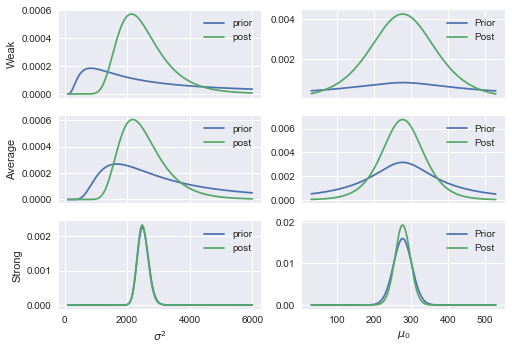

In [6]:
# Forgive me, matplotlib can get pretty verbose the more customization you want
plt.figure(figsize=(10,10))

plt.close('all')

row_titles = ['Weak', 'Average', 'Strong']
_, rows = plt.subplots(3, 2, sharex='col')
rows[2][0].set_xlabel(r'$\sigma^2$')
rows[2][1].set_xlabel(r'$\mu_0$')
for s2_pri, mu_pri, s2_po, mu_po, row, row_title in zip(s2_prior, mu_prior, s2_post, mu_post, rows, row_titles):
    row[0].set_ylabel(row_title)
    
    i_s2 = np.linspace(100, 6000, 1000)
    row[0].plot(i_s2, s2_pri.pdf(i_s2), label='prior')
    row[0].plot(i_s2, s2_po.pdf(i_s2), label='post')
    row[0].legend()


    i_mu = np.linspace(30, 530, 1000)
    mu_prior_samples = [mu_pri.pdf(i).mean() for i in i_mu]
    mu_post_samples = [mu_po.pdf(i).mean() for i in i_mu]
    row[1].plot(i_mu, mu_prior_samples, label='Prior')
    row[1].plot(i_mu, mu_post_samples, label='Post')
    row[1].legend()        

I can say that the change in prior strengths is very clear in all examples. For our weak prior, both parameters have very wide tails and are not very imformative. I chose the average to be seemingly appropriate for the data. The strong prior shows almost no change in the variance and only a slight slimming on the mean. 

## Problem 2

In [7]:
data = pd.read_csv('../hw1/footballscores.csv', index_col=0)

In [8]:
data['outcome'] = data.favorite - data.underdog
data['diff'] = data.outcome - data.spread
diff = data['diff']
diff.describe()

count    672.000000
mean       0.069940
std       13.859994
min      -47.500000
25%       -8.500000
50%       -0.500000
75%        9.000000
max       39.500000
Name: diff, dtype: float64

In [9]:
from scipy import interpolate

def draw_cdf(x, pdf, n=10000):
    ''' Gets a random sample using cdf method '''
    cdf = np.cumsum(pdf) / np.sum(pdf)
    inv_cdf = interpolate.interp1d(cdf, x)    
    return inv_cdf(np.random.rand(n))

In [30]:
def invchi2(x, v, s):
    return v * s**2 / stats.chi2.pdf(x, v)

ValueError: A value in x_new is below the interpolation range.

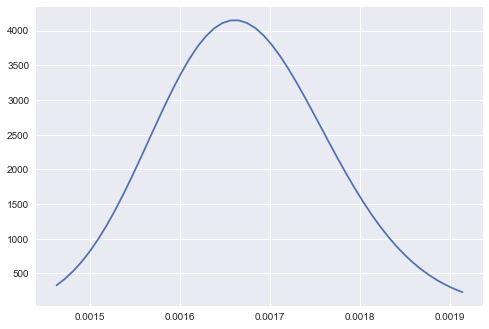

In [48]:
# I'm totally cheating here because inv chi2 doesnt exist in stats
v = 600
s = 14
invchi2 = stats.invgamma(v/2, scale=1/2)
x = np.linspace(*invchi2.ppf([0.01, 0.99]))
plt.plot(x, invchi2.pdf(x))
plt.hist(draw_cdf(x, invchi2.pdf(x)), density=True)

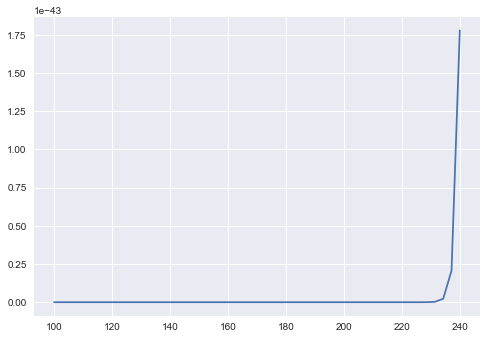

In [32]:
plt.plot(x, stats.chi2.pdf(x, v))